In [139]:
# ==============================================================================
#  라이브러리 임포트
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # 로컬에서는 tqdm.notebook 대신 일반 tqdm 사용
from tqdm.contrib.concurrent import thread_map
import joblib
import random

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import pairwise_distances, silhouette_score, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample


# joblib (병렬 처리를 위해)
from joblib import Parallel, delayed

# faiss (KNN 가속화를 위해)
import faiss

# 데이터 관련 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble
from Ensemble import EnsembleFaissKNN

#DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"

print("✔ 모든 라이브러리 임포트 완료!")

✔ 모든 라이브러리 임포트 완료!


In [140]:
# ==============================================================================
#  데이터 로드 함수
# ==============================================================================

# 이미지 로드 함수
def load_images_from_folder(base_path):
    """
    주어진 base_path 내의 서브폴더(라벨)에서 이미지를 로드하고,
    이미지 데이터, 라벨, 그리고 원본 이미지 경로를 포함하는 DataFrame을 반환합니다.
    (예: base_path/label_name/image.jpg 구조를 가정)
    """
    images = []
    labels = []
    image_paths = [] # 이미지 경로를 저장할 리스트 추가

    if not os.path.exists(base_path):
        raise FileNotFoundError(f"지정된 폴더를 찾을 수 없습니다: {base_path}\n"
                                f"경로를 올바르게 설정했는지 확인해주세요.")

    print(f"⏳ Loading images from: {base_path}")
    # base_path 바로 아래의 모든 폴더(라벨)를 순회합니다.
    for label_name in tqdm(os.listdir(base_path), desc="폴더 로드 중"):
        label_path = os.path.join(base_path, label_name)
        
        # 이것이 실제 라벨 폴더인지 확인합니다.
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                # 이미지 파일만 처리하도록 확장자 필터링
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            images.append(img)
                            labels.append(label_name)
                            image_paths.append(img_path) # 원본 이미지 경로 저장
                        else:
                            print(f"경고: {img_path} 이미지를 로드할 수 없습니다. (로드 실패)")
                    except Exception as e:
                        print(f"경고: {img_path} 로딩 중 오류 발생 - {e}")
                # else: (이미지 확장자가 아닌 파일은 무시)
        # else: (base_path 바로 아래에 파일이 있는 경우는 무시, 라벨 폴더 구조를 가정)

    df = pd.DataFrame({'image_data': images, 'label': labels, 'image_path': image_paths})
    print(f"✔ 총 {len(df)}개의 이미지 로드 완료.")
    return df

def visualize_features(X_feats, y_labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X_feats)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f'Feature Distribution via {method.upper()}')
    plt.colorbar(scatter, ticks=range(len(set(y_labels))))
    plt.tight_layout()
    plt.show()


In [141]:
def edge(img_bgr):
    # 1) 강제 리사이즈
    img_bgr = cv2.resize(img_bgr, (120, 120), interpolation=cv2.INTER_AREA)

    # 2) CLAHE → Gray → Blur → Denoise → Canny
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8,8))
    l = clahe.apply(l)
    img_eq = cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

    gray = cv2.cvtColor(img_eq, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    denoised = cv2.fastNlMeansDenoising(blurred, h=10, templateWindowSize=7, searchWindowSize=21)
    edges = cv2.Canny(denoised, 100, 230)   

    return edges

# 1) 공통: BGR → LAB → CLAHE(L) → BGR (필요 시)
def apply_clahe(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.createCLAHE(2.0, (8,8)).apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

# 3) Unsharp mask (SIFT 전용)
def unsharp(img_gray):
    blurred = cv2.GaussianBlur(img_gray, (3,3), 0)
    return cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# 4) Mild Gaussian blur (LBP/GLCM/Laws)
def mild_blur(img_gray):
    return cv2.GaussianBlur(img_gray, (3,3), 0)

In [142]:
def gray(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

In [143]:
def checkcol(img_bgr):
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    #image=cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8,8,8), [0,180, 0,256, 0,256])
    hist = cv2.normalize(hist, hist).flatten()
    h, s, v = cv2.split(hsv)
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hist_rgb = cv2.calcHist([rgb], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_rgb = cv2.normalize(hist_rgb, hist_rgb).flatten()
    hist_bgr = cv2.calcHist([img_bgr], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_bgr = cv2.normalize(hist_bgr, hist_bgr).flatten()
    #plt.imshow(v)
    #plt.title("Color")
    #plt.axis('off')
    #plt.show()
     # ✅ 2D 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(hist, color='blue')
    plt.title("Flattened HSV Histogram")
    plt.xlabel("Bin Index")
    plt.ylabel("Normalized Value")
    plt.tight_layout()
    plt.show()
    return hsv


In [144]:
# ==============================================================================
#  피쳐 추출 함수
# ==================================================================:============

def extract_color_histogram_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, (8,8,8), [0,180,0,256,0,256])
    return cv2.normalize(hist, hist).flatten()

def extract_sift_pca_mean(img_bgr, pca_model=None, n_components=32):
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    if descriptors is None or len(descriptors) == 0:
        return np.zeros(n_components if pca_model else 128, dtype=np.float32)

    if pca_model is None:
        pca_model = PCA(n_components=n_components)
        descriptors_pca = pca_model.fit_transform(descriptors)
    else:
        descriptors_pca = pca_model.transform(descriptors)

    mean_vector = np.mean(descriptors_pca, axis=0)
    return mean_vector.astype(np.float32)

def extract_glcm_features(image):
    if image is None:
        num_props = 6
        num_distances = 3
        num_angles = 4
        return np.zeros(num_props * num_distances * num_angles)
        
    img_glcm = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_glcm = mild_blur(img_glcm)
    img_glcm = apply_clahe(cv2.cvtColor(img_glcm, cv2.COLOR_GRAY2BGR))
    gray_image = cv2.cvtColor(img_glcm, cv2.COLOR_BGR2GRAY)

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    try:
        glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
        
        props_to_extract = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        glcm_features = []
        for prop in props_to_extract:
            glcm_features.append(graycoprops(glcm, prop).ravel())
            
        return np.concatenate(glcm_features)
    except Exception as e:
        print(f"GLCM 추출 중 오류 발생: {e}")
        num_props = 6
        num_distances = len(distances) 
        num_angles = len(angles)   
        return np.zeros(num_props * num_distances * num_angles)

def extract_hog_features(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    img = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    features = hog(gray,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True,
                   feature_vector=True)
    return features.astype(np.float32)

def extract_sift_descriptors_from_array(image):
    img = apply_clahe(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image=unsharp(img)

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_image, None)

    return des

def extract_lbp_features_from_array(image, P=8, R=1, method='uniform'):
    image=apply_clahe(image)
    gray_image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_image = local_binary_pattern(gray_image, P, R, method=method)

    max_bins = P * (P - 1) + 3 if method == 'default' else P + 2
    hist, _ = np.histogram(lbp_image.ravel(), bins=max_bins, range=(0, max_bins), density=True)
    return hist


# Laws' Texture Energy - 기존과 동일
def extract_laws_energy_features(image, window_size=15):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray=mild_blur(image_gray)

    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)


def learn_bovw_vocabulary(all_sift_descriptors, num_clusters=200):
    filtered = [des for des in all_sift_descriptors if des is not None and len(des) > 0]
    feature_dims = {des.shape[1] for des in filtered}
    if len(feature_dims) > 1:
        raise ValueError(f"❌ BoVW 학습용 SIFT 디스크립터들의 차원이 일치하지 않음: {feature_dims}")

    concatenated_descriptors = np.vstack(filtered)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, _, centers = cv2.kmeans(
        concatenated_descriptors.astype(np.float32),
        num_clusters, None, criteria, 10, flags
    )
    return centers

def create_bovw_histogram(sift_descriptors, vocabulary):
    num_clusters = vocabulary.shape[0]
    if sift_descriptors is None or len(sift_descriptors) == 0:
        return np.zeros(num_clusters, dtype=np.float32)

    try:
        distances = np.linalg.norm(
            vocabulary[None, :, :] - sift_descriptors[:, None, :], axis=2
        )
        closest_clusters = np.argmin(distances, axis=1)
        histogram = np.bincount(closest_clusters, minlength=num_clusters).astype(np.float32)
        histogram = cv2.normalize(histogram, None, norm_type=cv2.NORM_L2).flatten()
        return histogram

    except Exception as e:
        print(f"⚠️ BoVW 히스토그램 생성 오류: {e}")
        return np.zeros(num_clusters, dtype=np.float32)


def parallel_create_bovw_histograms(descriptor_list, vocabulary, n_jobs=6):
    histograms = Parallel(n_jobs=n_jobs)(
        delayed(create_bovw_histogram)(desc, vocabulary) for desc in descriptor_list
    )
    return np.array(histograms, dtype=np.float32)

print("✔ 특징 추출 함수 정의 완료")

✔ 특징 추출 함수 정의 완료


In [158]:
# ==============================================================================
#  분류 모델 및 학습/평가 함수
# ==============================================================================
# 유클리드 거리 기반 Faiss KNN 학습 (수정됨)

def combine_features(*feature_arrays):
    """주어진 특징 배열들을 가로로 결합합니다."""
    return np.hstack(feature_arrays)

def train_faiss_knn_euclidean(X_train, y_train, n_neighbors=3):
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]

    index = faiss.IndexFlatL2(D)
    index.add(X_train)

    return index, y_train, n_neighbors

# 유클리드 거리 기반 Faiss KNN 예측 (수정됨)
def predict_faiss_knn_euclidean(index, y_train_labels, n_neighbors, X_test):
    X_test = X_test.astype(np.float32)

    distances, indices = index.search(X_test, n_neighbors)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

# 기존 predict_faiss_knn_euclidean 함수를 수정하거나, 아래 함수를 추가합니다.
# 이 함수는 k개의 가장 가까운 이웃의 라벨을 반환합니다.
def predict_faiss_knn_topk(faiss_index, train_labels_encoded, query_features, k=10):
    if faiss_index is None:
        raise ValueError("Faiss 인덱스가 학습되지 않았습니다.")
    if query_features.shape[0] == 0:
        return np.array([]), np.array([]), np.array([])

    D, I = faiss_index.search(query_features, k)
    predicted_neighbor_labels = train_labels_encoded[I]

    return D, I, predicted_neighbor_labels

# 참고: 기존 predict_faiss_knn_euclidean 함수는 단순히 k=1로 설정하고 첫 번째 라벨을 반환하는 식으로 동작할 수 있습니다.
# 만약 기존 predict_faiss_knn_euclidean 함수가 k를 인자로 받는다면, 그 함수를 활용해도 좋습니다.
# 여기서는 Top-k 결과를 직접 다룰 수 있도록 predict_faiss_knn_topk를 사용합니다.

# Task2 Accuracy (Top-K Same-Class)를 계산하는 함수
def task2_score(y_true, topk_preds, topk=10):
    match_counts = []
    for true_label, pred_list_np in zip(y_true, topk_preds):
        # NumPy 배열을 Python 리스트로 변환하여 .count() 메서드 사용
        pred_list = pred_list_np.tolist()
        # topk_preds의 각 요소(pred_list)는 실제 라벨이 포함된 횟수 / topk
        # 예를 들어, topk=10일 때, 'car' 라벨이 3번 등장하면 3/10 = 0.3
        match_counts.append(pred_list.count(true_label) / topk)
    return np.mean(match_counts)

def test(model_tuple, X_test, y_test, average='weighted', topk=10):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ▶ KNN 예측 중 (Faiss 사용, k={n_neighbors})...")
    
    # Top-1 예측 (기존)
    y_pred = predict_faiss_knn_euclidean(faiss_index, y_train_labels, n_neighbors, X_test)

    # Top-k 예측을 위해 predict_faiss_knn_topk 사용
    # D, I는 필요 없으므로 _ 처리
    _, _, topk_predicted_labels_encoded = predict_faiss_knn_topk(faiss_index, y_train_labels, X_test, k=topk)

    print("  ✔ 예측 완료.")
    
    # Top-1 Accuracy
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)

    # Top-k Accuracy 계산 (기존 방식)
    topk_correct_count = 0
    for i in range(len(y_test)):
        # y_test[i] (실제 라벨)이 상위 k개 예측 라벨 중 하나라도 있는지 확인
        if y_test[i] in topk_predicted_labels_encoded[i]:
            topk_correct_count += 1
    topk_acc = topk_correct_count / len(y_test)

    # --- 여기에 Task2 Accuracy (Top-10 Same-Class) 계산 및 출력 추가 ---
    # task2_score 함수가 정의되어 있어야 합니다.
    # 만약 task2_score 함수가 아직 정의되지 않았다면, 이전에 제공된 코드를 추가해야 합니다.
    # (예: def task2_score(y_true, topk_preds, topk=10): ... )
    task2_acc = task2_score(y_test, topk_predicted_labels_encoded, topk=topk)
    # ------------------------------------------------------------------

    print(f"[Top-1 Accuracy]    {acc:.4f}")
    print(f"[Task2 Accuracy (Top-{topk} Same-Class)] {task2_acc:.4f}") # 이 줄을 추가
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return y_pred

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [146]:
def augment_image(img):
    choice = random.choice(['flip', 'rotate', 'brightness', 'blur', 'noise'])
    if choice == 'flip':
        return cv2.flip(img, 1)
    elif choice == 'rotate':
        angle = random.uniform(-15, 15)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    elif choice == 'brightness':
        factor = random.uniform(0.7, 1.3)
        return np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    elif choice == 'blur':
        return cv2.GaussianBlur(img, (5, 5), 0)
    elif choice == 'noise':
        noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
        return cv2.add(img, noise)
    return img

def augment_to_balance_min(df, target_min_per_class=500, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    augmented_rows = []

    for label, group in df.groupby('label'):
        n_current = len(group)
        n_needed = target_min_per_class - n_current

        if n_needed <= 0:
            print(f"✅ {label}: {n_current}개 → 그대로 유지 (증강 없음)")
            augmented_rows.append(group)
        else:
            print(f"➕ {label}: {n_current}개 → {target_min_per_class}개로 증강 중 ({n_needed}개 생성)")
            samples_to_augment = group.sample(n=n_needed, replace=True, random_state=seed)

            new_rows = []
            for _, row in samples_to_augment.iterrows():
                new_img = augment_image(row['image_data'])
                # 증강된 이미지에는 image_path를 새로 할당할 필요가 없으므로 image_data만 추가
                new_rows.append({
                    'label': row['label'],
                    'image_data': new_img
                })
            augmented_rows.append(group)
            augmented_rows.append(pd.DataFrame(new_rows))

    balanced_df = pd.concat(augmented_rows).reset_index(drop=True)
    return balanced_df


In [147]:
DATASET_BASE_PATH = "C:/Users/bvb09/recaptcha-dataset" 

try:
    images_df = load_images_from_folder(os.path.join(DATASET_BASE_PATH, 'images'))
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")
except FileNotFoundError as e:
    print(f"오류: {e}")
    

# 2. 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스: {le.classes_}")

images_df = images_df.groupby('label').apply(
    lambda g: g.sample(n=1500, random_state=42) if g.name in ['Car', 'Bus'] else g
).reset_index(drop=True)

images_df = augment_to_balance_min(images_df)
images_df['label_encoded'] = le.fit_transform(images_df['label'])

# 전체 이미지 데이터에 대해 전처리 수행
#print("⏳ 전체 이미지 전처리 중...")
#images_df['processed_image_data'] = [preprocess_image(img) for img in tqdm(images_df['image_data'], desc="이미지 전처리")]
#print("✔ 전체 이미지 전처리 완료.")


⏳ Loading images from: C:/Users/bvb09/recaptcha-dataset\images


폴더 로드 중: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


✔ 총 12683개의 이미지 로드 완료.
✔ 총 12683개의 이미지 로드 완료.
✔ 라벨 인코딩 완료. 클래스: ['Bicycle' 'Bridge' 'Bus' 'Car' 'Chimney' 'Crosswalk' 'Hydrant'
 'Motorcycle' 'Palm' 'Traffic Light']
✅ Bicycle: 1299개 → 그대로 유지 (증강 없음)
✅ Bridge: 553개 → 그대로 유지 (증강 없음)
✅ Bus: 1500개 → 그대로 유지 (증강 없음)
✅ Car: 1500개 → 그대로 유지 (증강 없음)
➕ Chimney: 431개 → 500개로 증강 중 (69개 생성)


C:\Users\bvb09\AppData\Local\Temp\ipykernel_24848\2780136523.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_df = images_df.groupby('label').apply(


✅ Crosswalk: 1260개 → 그대로 유지 (증강 없음)
✅ Hydrant: 1032개 → 그대로 유지 (증강 없음)
✅ Motorcycle: 679개 → 그대로 유지 (증강 없음)
✅ Palm: 932개 → 그대로 유지 (증강 없음)
✅ Traffic Light: 905개 → 그대로 유지 (증강 없음)


In [148]:
features_color_all = np.array([extract_color_histogram_features(img) for img in tqdm(images_df['image_data'], desc="Color Histogram 추출")])

Color Histogram 추출: 100%|██████████| 10160/10160 [00:00<00:00, 14715.54it/s]


In [149]:
features_lbp_all = np.array([extract_lbp_features_from_array(img) for img in tqdm(images_df['image_data'], desc="LBP 추출")])

LBP 추출: 100%|██████████| 10160/10160 [00:44<00:00, 227.80it/s]


In [150]:
hog_list = [
    extract_hog_features(img)
    for img in tqdm(images_df['image_data'], desc="HOG 추출")
]
features_hog_all = np.vstack(hog_list)
print(f"  - HOG 원본 특징 차원: {features_hog_all.shape}")
pca_hog = PCA(n_components=50, random_state=42)
features_hog_all = pca_hog.fit_transform(features_hog_all)
print(f"  - HOG PCA 변환 완료. 변환 후 차원: {features_hog_all.shape}")

HOG 추출: 100%|██████████| 10160/10160 [00:47<00:00, 215.44it/s]


  - HOG 원본 특징 차원: (10160, 1296)
  - HOG PCA 변환 완료. 변환 후 차원: (10160, 50)


In [151]:
#features_glcm_all = np.array([extract_glcm_features(img) for img in tqdm(images_df['image_data'], desc="GLCM 추출")])

In [152]:
#features_laws_all = np.array([extract_laws_energy_features(img) for img in tqdm(images_df['image_data'], desc="Laws' Texture 추출")])

In [153]:
def pca_reduce_descriptors(sift_descriptors_list_all, n_components=64):
    """
    모든 이미지의 SIFT 디스크립터에 대해 PCA를 적용해 차원 축소.
    PCA는 전체 디스크립터에서 1회 학습한 뒤, 각 디스크립터에 transform만 적용.
    """
    # 유효한 디스크립터만 추출 (None 제거, 최소 차원 이상)
    valid_descriptors = [d for d in sift_descriptors_list_all if d is not None and len(d) >= n_components]
    
    if len(valid_descriptors) == 0:
        print("❌ PCA 학습할 디스크립터가 충분하지 않음. 차원 축소를 생략합니다.")
        return sift_descriptors_list_all

    # 전체 디스크립터 결합
    all_descriptors = np.vstack(valid_descriptors)

    # PCA 학습
    print(f"🔍 PCA 학습 중... (입력 차원: {all_descriptors.shape[1]} → {n_components})")
    pca_sift = PCA(n_components=n_components, random_state=42)
    pca_sift.fit(all_descriptors)

    # 병렬 변환 함수
    def transform_if_valid(desc):
        if desc is None or len(desc) < n_components:
            return desc
        return pca_sift.transform(desc)

    # 병렬 적용
    print("⚙ PCA 변환 병렬 적용 중...")
    reduced_descriptors = Parallel(n_jobs=6)(
        delayed(transform_if_valid)(desc) for desc in sift_descriptors_list_all
    )
    
    print("✅ PCA 축소 완료")
    return reduced_descriptors

In [154]:
# SIFT 디스크립터 추출
sift_descriptors_list_all = [extract_sift_descriptors_from_array(img) for img in tqdm(images_df['image_data'], desc="SIFT Descriptors 추출")]

# 전체 이미지 수
total_count = len(sift_descriptors_list_all)

# PCA 학습에 사용할 디스크립터만 필터링 (128차원인 경우만)
all_descriptors = [des for des in sift_descriptors_list_all if des is not None and des.shape[1] == 128]
pca_image_count = len(all_descriptors)

if len(all_descriptors) > 0: # PCA 학습할 데이터가 있을 경우에만 진행
    X_all_sift_for_pca = np.vstack(all_descriptors) # SIFT PCA를 위한 데이터
    pca_sift = PCA(n_components=64, random_state=42)
    pca_sift.fit(X_all_sift_for_pca)

    print(f"📊 전체 이미지 수: {total_count}")
    print(f"📊 PCA 학습에 사용된 SIFT 디스크립터가 있는 이미지 수: {pca_image_count}")
    print(f"📊 PCA 학습에 사용된 전체 SIFT 벡터 수: {X_all_sift_for_pca.shape[0]}")

    # PCA 변환 적용
    sift_descriptors_list_all = [
        pca_sift.transform(des) if des is not None and des.shape[1] == 128 else None
        for des in sift_descriptors_list_all
    ]
    print("✅ SIFT 디스크립터 PCA 변환 완료.")
else:
    print("⚠️ SIFT 디스크립터가 없거나 PCA 학습에 사용할 데이터가 충분하지 않습니다. SIFT PCA를 건너뜜니다.")


SIFT Descriptors 추출: 100%|██████████| 10160/10160 [07:05<00:00, 23.90it/s]


📊 전체 이미지 수: 10160
📊 PCA 학습에 사용된 SIFT 디스크립터가 있는 이미지 수: 10160
📊 PCA 학습에 사용된 전체 SIFT 벡터 수: 1755861
✅ SIFT 디스크립터 PCA 변환 완료.


In [155]:
# ----------------------------------------
# 1. 전체 SIFT → BoVW Vocabulary 학습
# ----------------------------------------
valid_sift_descriptors_all = [d for d in sift_descriptors_list_all if d is not None and len(d) > 0]
if valid_sift_descriptors_all:
    bovw_vocabulary = learn_bovw_vocabulary(valid_sift_descriptors_all, num_clusters=200)
    print(f"✔ 전체 BoVW Vocabulary 학습 완료 ({bovw_vocabulary.shape[0]} clusters)")
else:
    print("⚠️ 유효한 SIFT 디스크립터가 없어 BoVW Vocabulary를 학습할 수 없습니다.")
    # Vocabulary가 없으면 BoVW 히스토그램 생성 시 오류가 발생하므로, 빈 Vocabulary를 정의합니다.
    bovw_vocabulary = np.zeros((200, 64)) # 예시: 200 클러스터, SIFT PCA 차원 64로 가정


# ----------------------------------------
# 2. BoVW Histogram 전체 생성
# ----------------------------------------
bovw_hist_all = np.array(parallel_create_bovw_histograms(sift_descriptors_list_all, bovw_vocabulary, n_jobs=-1))
print(f"  - BoVW Histogram 차원: {bovw_hist_all.shape}")
print("✔ 특징 추출 완료.")
# ----------------------------------------
# 3. 조합: color+lbp+sift+hog
# ----------------------------------------
feature_combo = ('color', 'lbp', 'sift', 'hog')
X_features_list = [
    features_color_all,
    features_lbp_all,
    features_hog_all,
    bovw_hist_all
]
X_all_combined = combine_features(*X_features_list).astype(np.float32)
y_all_encoded = images_df['label_encoded'].values
print(f"✔ 학습 데이터 통합 특징 벡터 생성 완료. Shape: {X_all_combined.shape}")

# ----------------------------------------
# 4. Faiss KNN 전체 학습
# ----------------------------------------
faiss_index, train_labels_for_pred, _ = train_faiss_knn_euclidean(X_all_combined, y_all_encoded, n_neighbors=10)
print("✔ 전체 데이터로 Faiss KNN 학습 완료")

✔ 전체 BoVW Vocabulary 학습 완료 (200 clusters)
  - BoVW Histogram 차원: (10160, 200)
✔ 특징 추출 완료.
✔ 학습 데이터 통합 특징 벡터 생성 완료. Shape: (10160, 772)
✔ 전체 데이터로 Faiss KNN 학습 완료


In [ ]:
# ==============================================================================
#  추출된 피처, 라벨, 학습된 모델들 저장 (새로 추가)
# ==============================================================================
try:
    joblib.dump(X_all_combined, FEATURES_PATH)
    joblib.dump(y_all_encoded, LABELS_PATH)
    joblib.dump(le, LABEL_ENCODER_PATH) # 라벨 인코더 저장
    
    joblib.dump(pca_hog, PCA_HOG_PATH)
    joblib.dump(pca_sift, PCA_SIFT_PATH)
    
    joblib.dump(kmeans_bovw, KMEANS_BOVW_PATH)
    joblib.dump(bovw_visual_words, VISUAL_WORDS_PATH)

    print(f"✔ 모든 학습 관련 파일이 '{SAVE_DIR}' 폴더에 저장되었습니다.")
except Exception as e:
    print(f"오류 발생: 파일 저장에 실패했습니다. {e}")



⏳ Loading images from: C:/Users/bvb09/Downloads/test/images


폴더 로드 중: 100%|██████████| 10/10 [00:00<00:00, 253.05it/s]


✔ 총 100개의 이미지 로드 완료.
✔ 총 100개의 쿼리 이미지 로드 완료.
⏳ 쿼리 이미지 기본 특징 추출 중 (Color, HOG, LBP, SIFT descriptors)...


Query Color Histogram 추출: 100%|██████████| 100/100 [00:00<00:00, 20006.22it/s]


  - Color Histogram 특징 차원: (100, 512)


Query LBP 추출: 100%|██████████| 100/100 [00:00<00:00, 461.79it/s]


  - LBP 특징 차원: (100, 10)


Query HOG 추출: 100%|██████████| 100/100 [00:00<00:00, 363.58it/s]


  - HOG 원본 특징 차원: (100, 1296)
  - HOG PCA 변환 완료. 변환 후 차원: (100, 50)


Query SIFT Descriptors 추출: 100%|██████████| 100/100 [00:01<00:00, 63.45it/s]


  - SIFT 디스크립터 PCA 변환 완료.
  - BoVW Histogram 차원: (100, 200)
✔ 쿼리 이미지 특징 추출 완료.
✔ 쿼리 이미지 통합 특징 벡터 생성 완료. Shape: (100, 772)
⏳ 쿼리 이미지 예측 및 Top-N Accuracy 계산 중...
✔ 쿼리 이미지 예측 완료.

--- Accuracy 계산 ---
총 쿼리 이미지 개수: 100개
Top-1 정답 개수: 59개
Top-1 Accuracy: 0.5900
Task2 Accuracy (Top-10 Same-Class): 0.4110

--- 쿼리 이미지 예측 결과 (Top-1) ---
쿼리 '0a72915c-270e-4c83-9e33-528d5706e7d2.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Bicycle


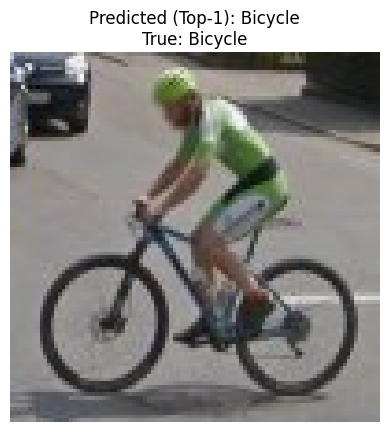

쿼리 '0ab9a21e-bf28-4c42-869d-2804482a1e56.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Bicycle


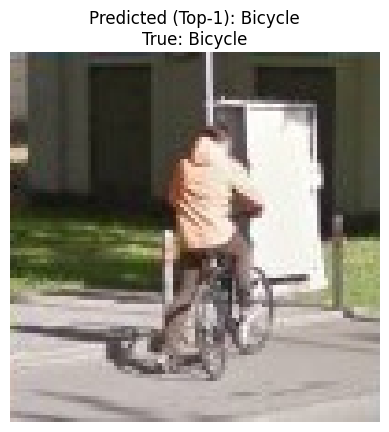

쿼리 '0b433101-7a68-4b29-b875-ac45c9680489.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Bicycle


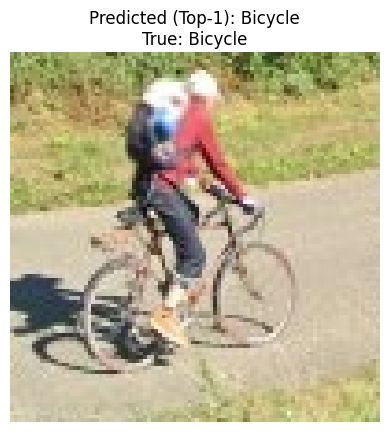

쿼리 '0d53a3b5-e4b2-4a5e-b478-a123441729bb.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Hydrant


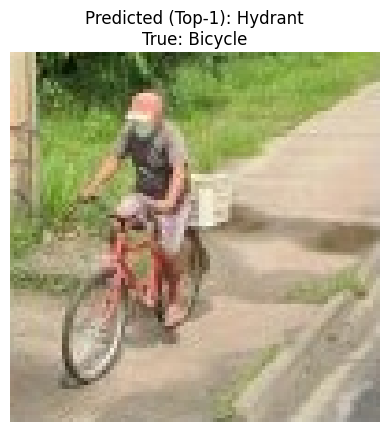

쿼리 '0ec1ea91-21fe-40db-acd5-7f2145904676.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Motorcycle


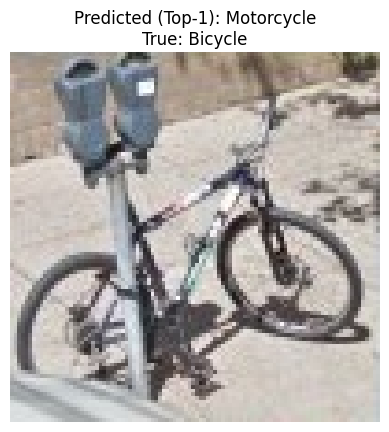

쿼리 '1a31e40a-986e-4e89-a3b4-a46a9aa96c31.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Bicycle


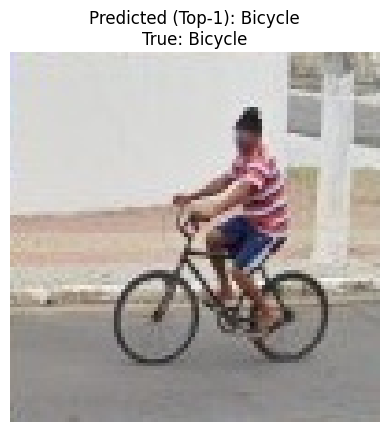

쿼리 '3ed32318-1795-4f75-8469-614aeec1e9e7.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Hydrant


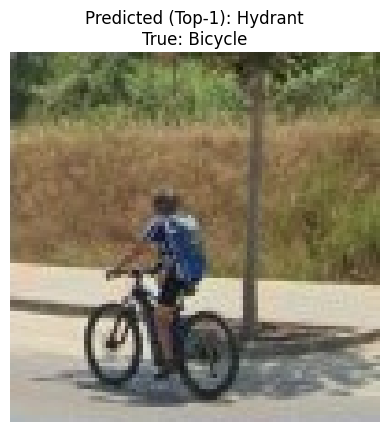

쿼리 '6b1d6264-b2be-45e5-b2a5-014338e12ef2.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Bicycle


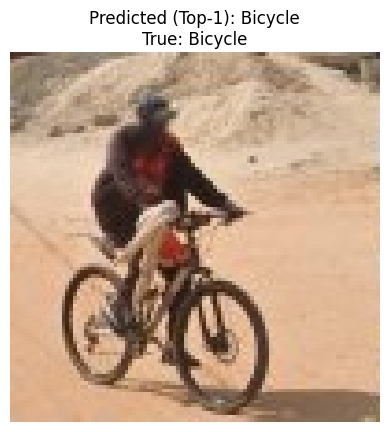

쿼리 '7fc10969-8f3c-4bf5-ab6d-da812773a89b.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Crosswalk


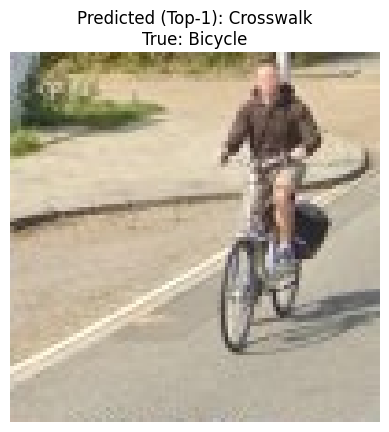

쿼리 '92963ada-70fc-4ca5-8821-ba2682551f32.jpg': 실제 라벨 = Bicycle, 예측 라벨 (Top-1) = Bicycle


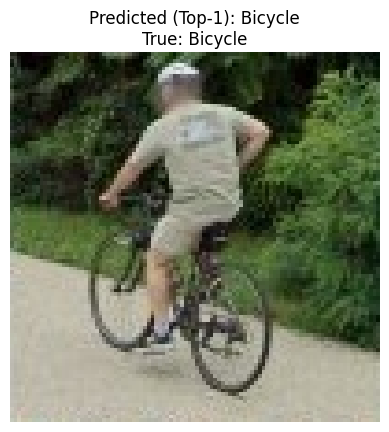

쿼리 '081aa302-b739-493d-8312-2337ba1be389.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Bridge


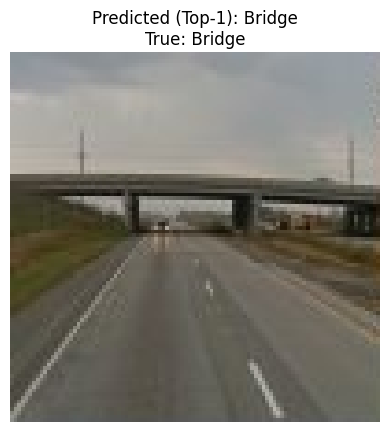

쿼리 '0a91630a-db06-4fb4-bba1-17ae331db395.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Bridge


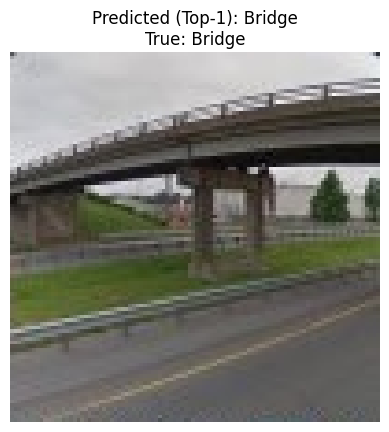

쿼리 '1c4dc73b-fe4d-4f33-8f93-7d4c02c7b5b7.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Bridge


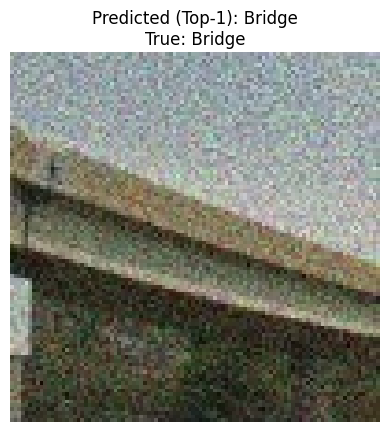

쿼리 '3aa99e62-717c-4ee9-929c-da91d369b183.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Car


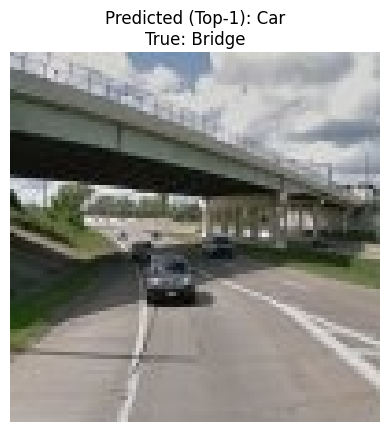

쿼리 '3aac8555-fbc3-4cbb-b2b7-ee97f5cf0458.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Palm


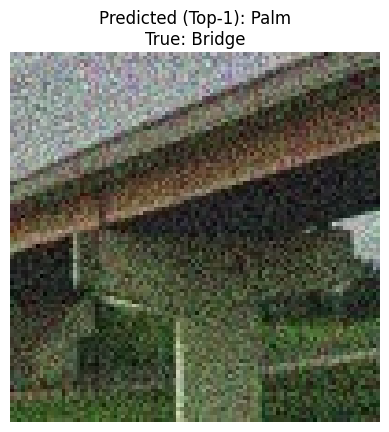

쿼리 '3af2abba-c6df-4cc1-9b96-2e5f270110be.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Car


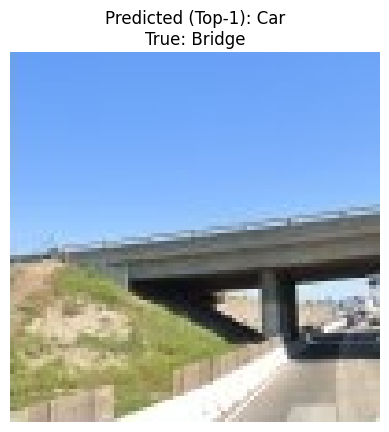

쿼리 '3de3dc2a-651e-4e24-aae3-811cef30e201.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Bridge


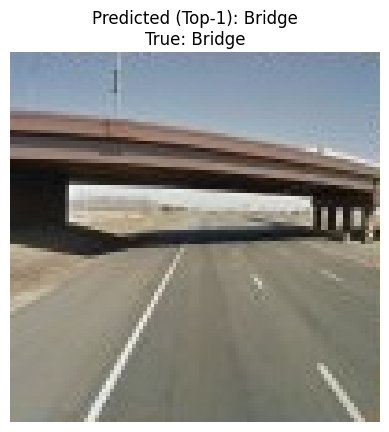

쿼리 '5f55ef8c-0dbd-4927-9b1b-e3a7f7a74378.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Car


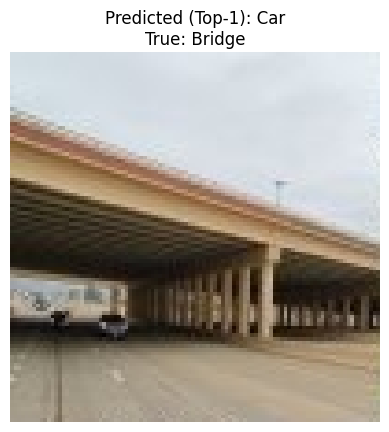

쿼리 '6bf272bb-9815-49bf-a593-e10017a115de.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Bridge


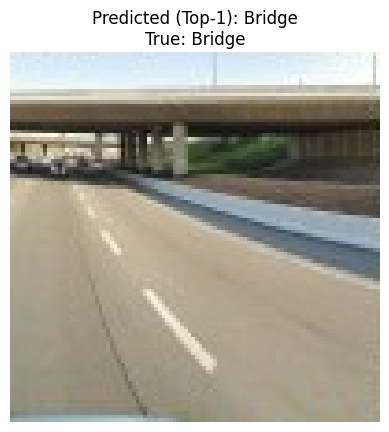

쿼리 '7fce9c5b-4ccb-415c-a3bf-692b6ff68ee4.jpg': 실제 라벨 = Bridge, 예측 라벨 (Top-1) = Crosswalk


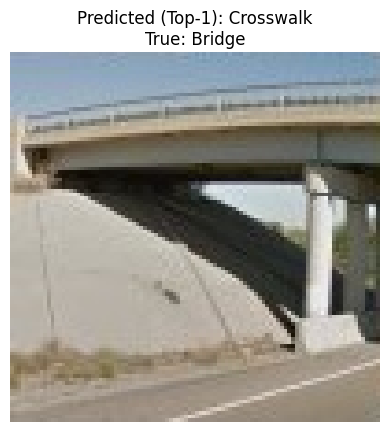

쿼리 '002c39c6-946f-4236-b45d-f128b3855bf6.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Bus


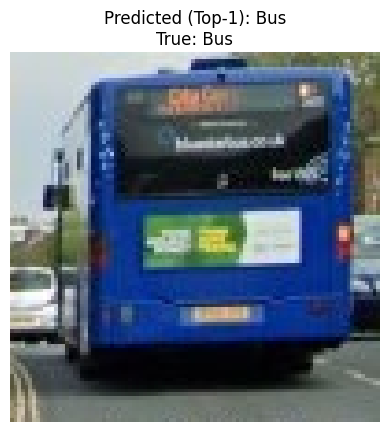

쿼리 '00d7cd9b-49a3-48c3-9f7d-1c627e39c5d9.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Bus


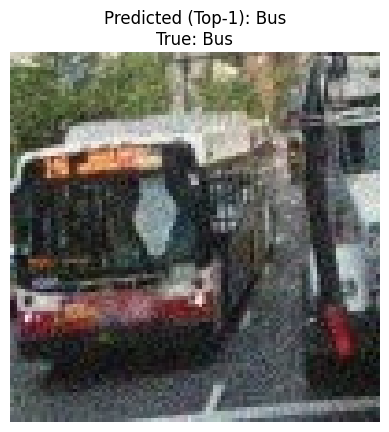

쿼리 '0a319951-345e-4a1e-8508-5e6477d3fbfe.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Car


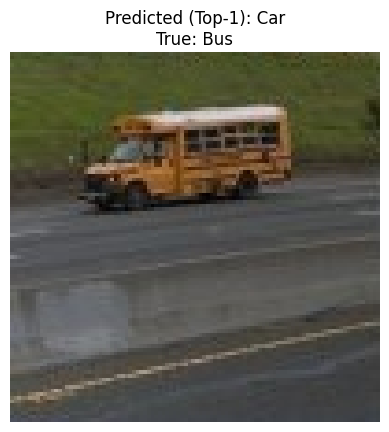

쿼리 '0a727049-80e7-46b1-98ea-9d06359d86f3.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Crosswalk


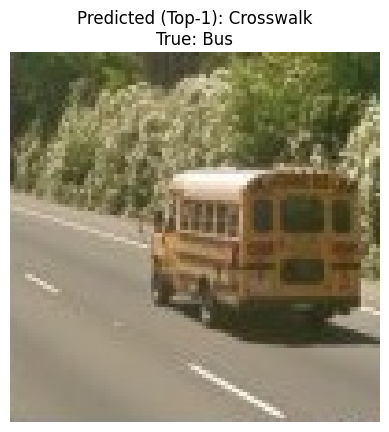

쿼리 '0b6e6ac9-d4fe-400d-abcb-3c9d95c4cd6f.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Bridge


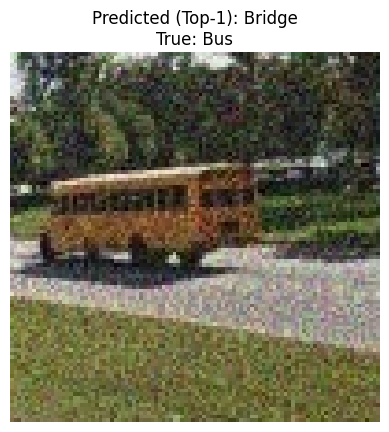

쿼리 '1d1b929b-0f69-4778-900b-a47cf51b7616.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Bus


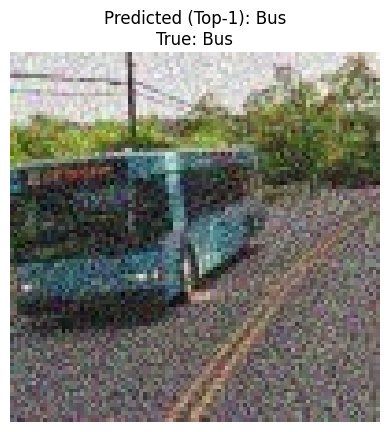

쿼리 '1f06bfb6-a155-4031-9db0-9b9f4061504f.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Car


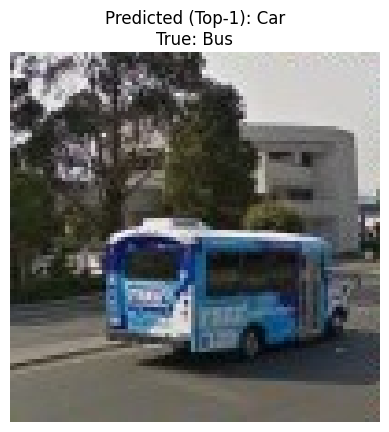

쿼리 '1fe08f3c-a339-45ac-b895-008bd0db39af.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Crosswalk


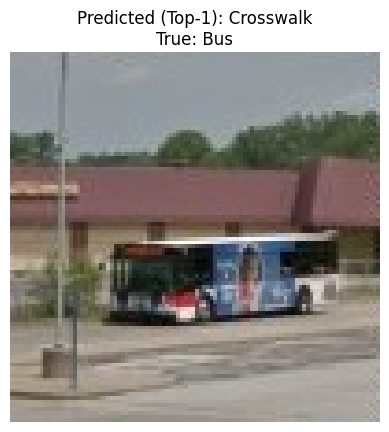

쿼리 '2a4fe936-4856-45e8-be48-30713832b7c5.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Bus


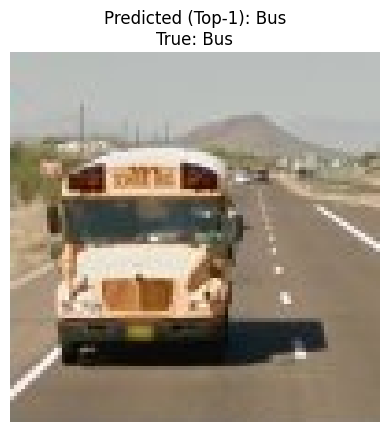

쿼리 '3a347165-3603-4ddd-9c08-aee2cc63f173.jpg': 실제 라벨 = Bus, 예측 라벨 (Top-1) = Bus


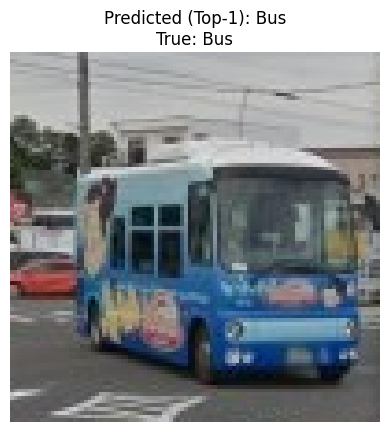

쿼리 '01d8b119-d8ff-4bca-8cc2-830c8389e1ee.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Bus


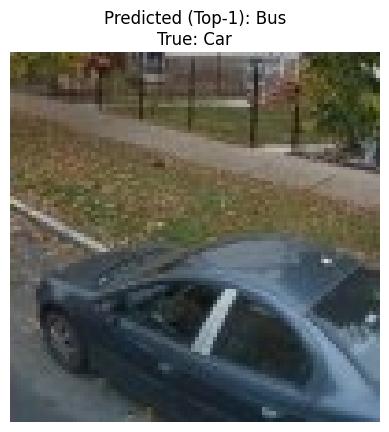

쿼리 '0372c38d-8ed2-4ed8-bbbb-b95b5b909fa7.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Car


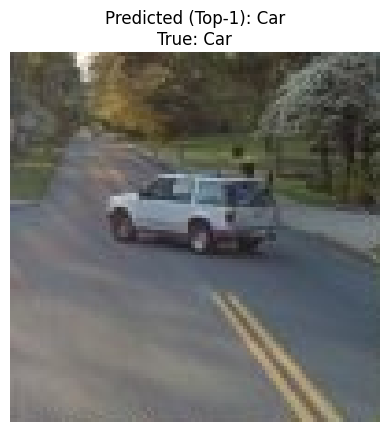

쿼리 '03c281c7-3cbd-440d-ad5f-f34aaae4a0e6.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Hydrant


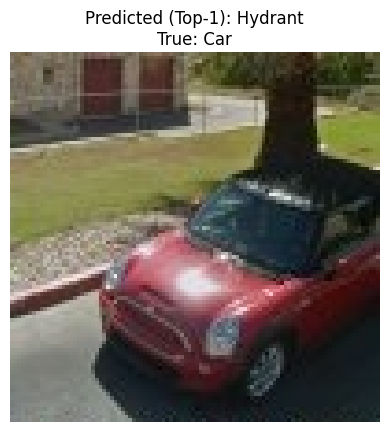

쿼리 '0b34a333-7205-4bfd-987f-b2056849d109.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Car


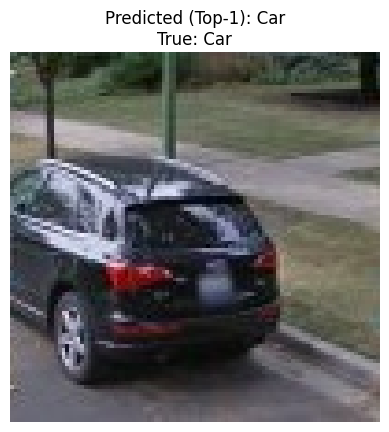

쿼리 '0d83d713-cdd0-4022-a564-90e170121bb7.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Car


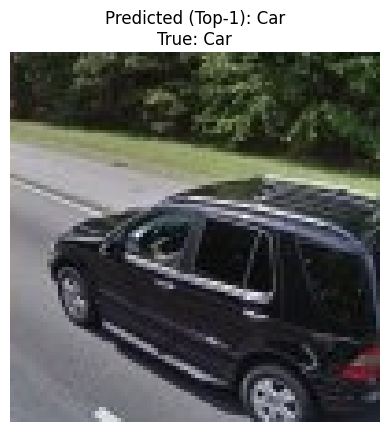

쿼리 '193b96c7-d795-48a9-ade2-0d7f7a4bf3c5.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Car


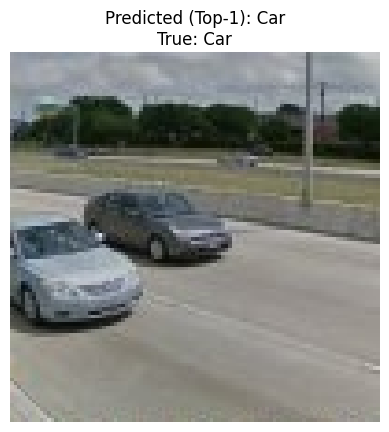

쿼리 '29e041d3-59ca-44bb-a7f7-7a015bf9b10d.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Bridge


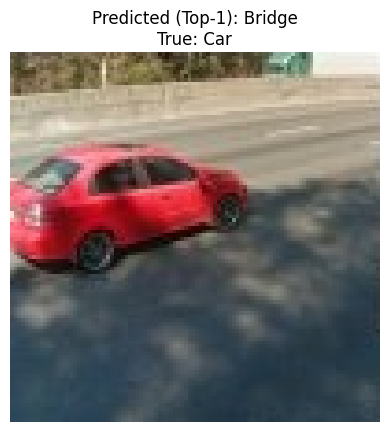

쿼리 '3ffa6670-7359-4317-b969-97e626251dcf.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Hydrant


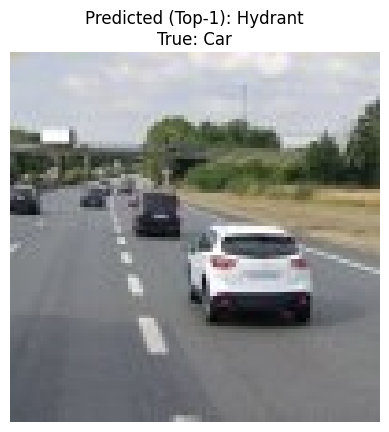

쿼리 '7f5813c7-9ec4-4753-9d90-abde66190786.jpg': 실제 라벨 = Car, 예측 라벨 (Top-1) = Bridge


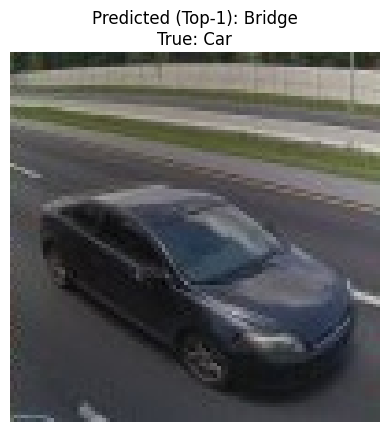

쿼리 'Car$1d9ca91bc678ecc6119c5cc26d5a8c48.png': 실제 라벨 = Car, 예측 라벨 (Top-1) = Crosswalk


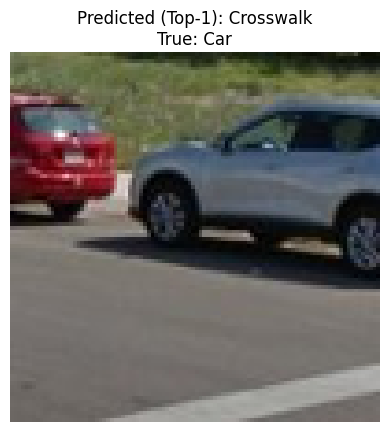

쿼리 'Chimney$04dcca03f490c28770efecf0ee796db0.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Bridge


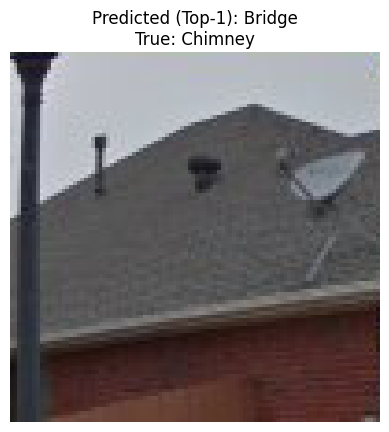

쿼리 'Chimney$09f7ff0aed72d5597bcef6aaed8a7840.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


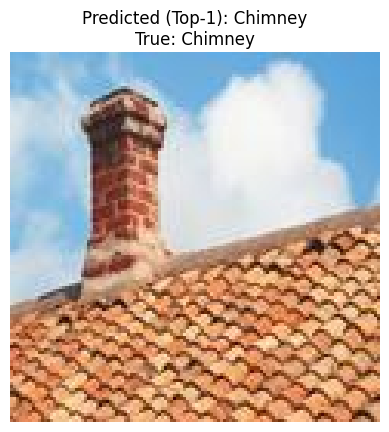

쿼리 'Chimney$34346eaf57bac71738f0d751b8d5a7a3.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


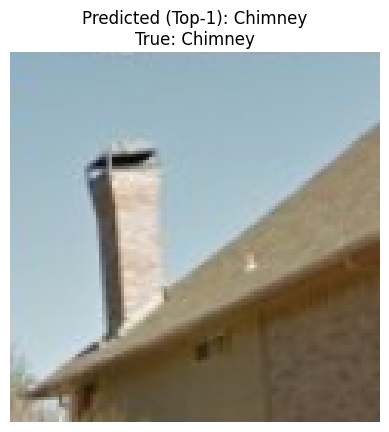

쿼리 'Chimney$5a14c817b1e3452c488f5cde111f794e.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


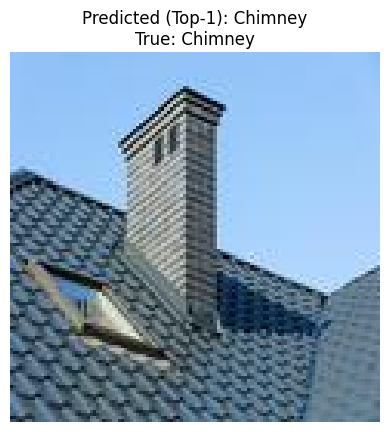

쿼리 'Chimney$6250c7e26b7409d9896a4d11afdc92a8.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


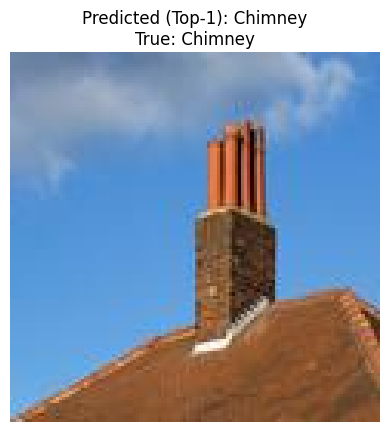

쿼리 'Chimney$79dc349ec460dfd0db3b36dfc993dc3a.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


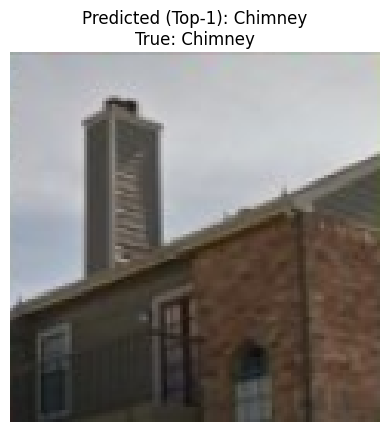

쿼리 'Chimney$7c8471087f69da59c445958254f8768b.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


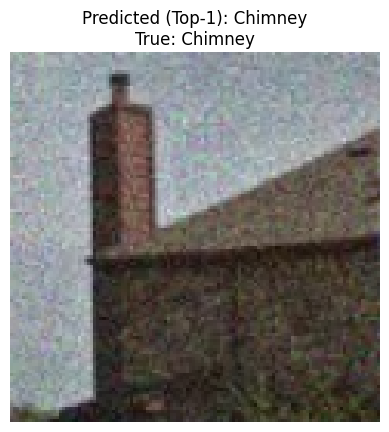

쿼리 'Chimney$7ec14a2af33112b8e8642dacad49a7cc.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


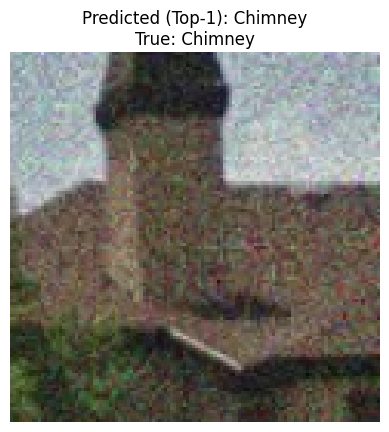

쿼리 'Chimney$84390f5d95f9c20243b1acaa53daf69c.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


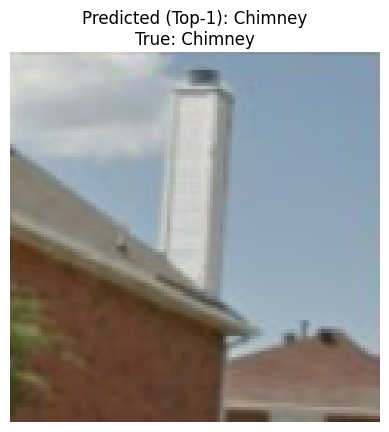

쿼리 'Chimney$9c5796638d7e53501140822e63235607.png': 실제 라벨 = Chimney, 예측 라벨 (Top-1) = Chimney


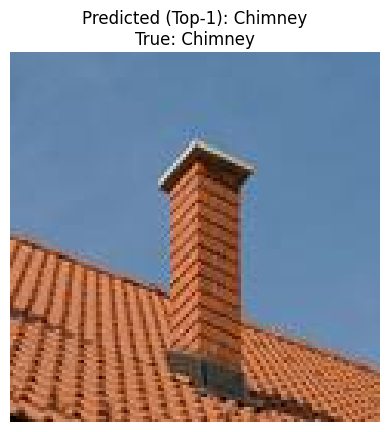

쿼리 '00c4ba7c-617b-4a78-acc0-7c7e3479caf2.jpg': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


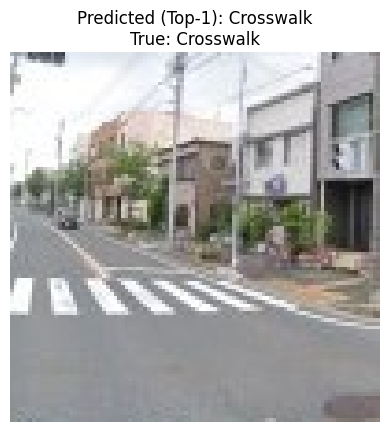

쿼리 '0141de6e-3d49-4069-862f-23dc28ee05a4.jpg': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


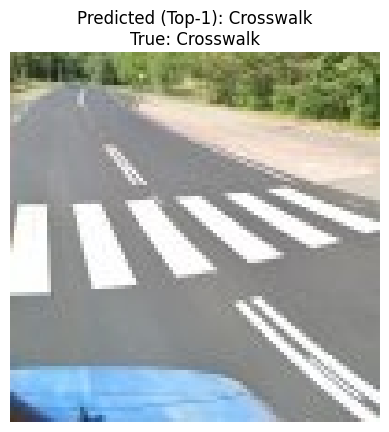

쿼리 '2dd8b46f-ca6e-4f81-aecf-a91d4d922803.jpg': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


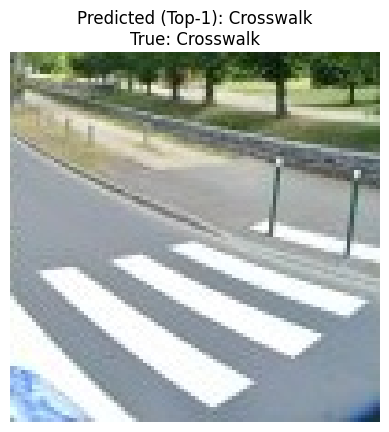

쿼리 '2e41a6f0-1537-432d-98f9-d5681d5f50dd.jpg': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


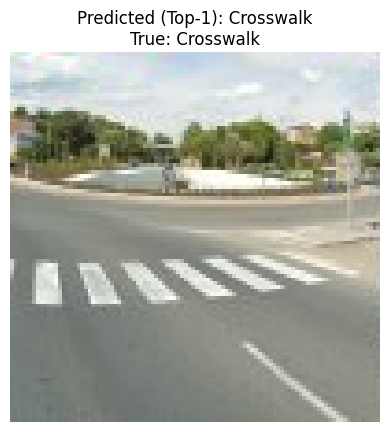

쿼리 '3a73d63e-5bdc-462e-8fe8-4a010f94c1e6.jpg': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


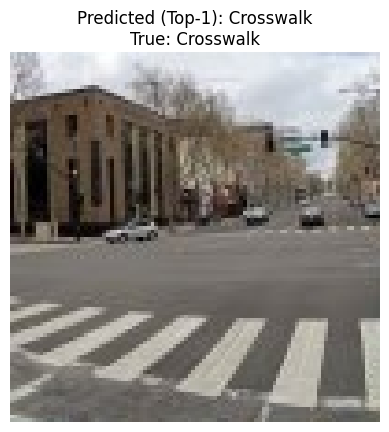

쿼리 '7607e588-ac6a-47e5-a9d3-166be6492dfb.jpg': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


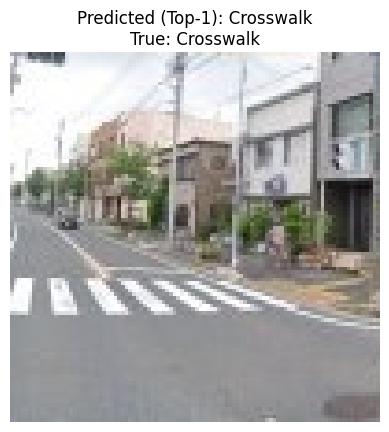

쿼리 '97e73494-2f7c-4bec-9c32-3bcbbbb9aab7.jpg': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Bus


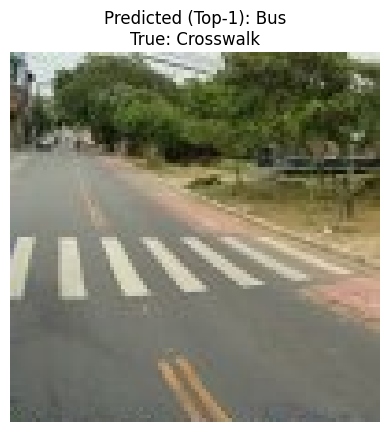

쿼리 'Crosswalk$0f89f2d78d315317bfda9292aa77e363.png': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


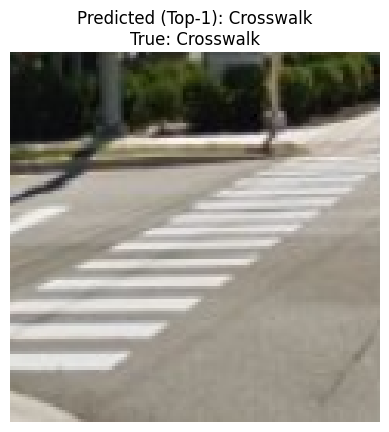

쿼리 'Crosswalk$1a9109073614ad5ac4f3be5ed1f1ef0e.png': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


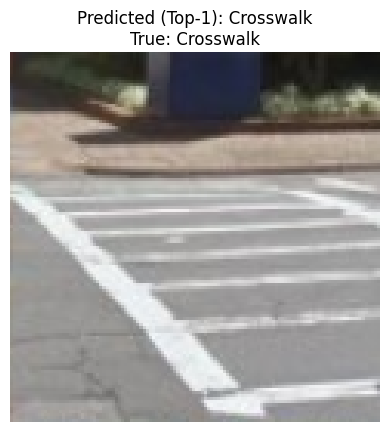

쿼리 'Crosswalk$1c36f7bad0c5740eb2a7420f4f14841e.png': 실제 라벨 = Crosswalk, 예측 라벨 (Top-1) = Crosswalk


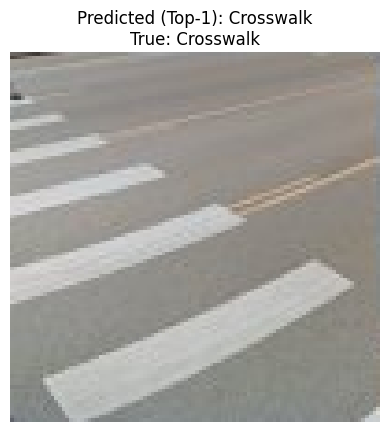

쿼리 '00bd0cb8-180e-4381-9ca8-c1e792edb315.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Hydrant


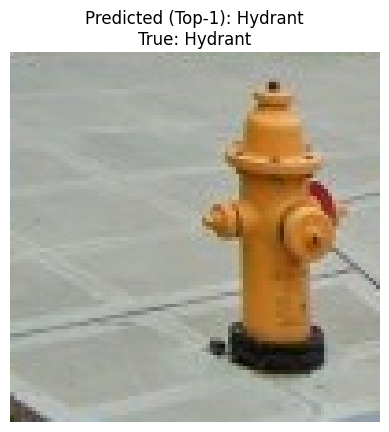

쿼리 '00ec1184-eed1-4978-879d-c6d96f0e352e.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Hydrant


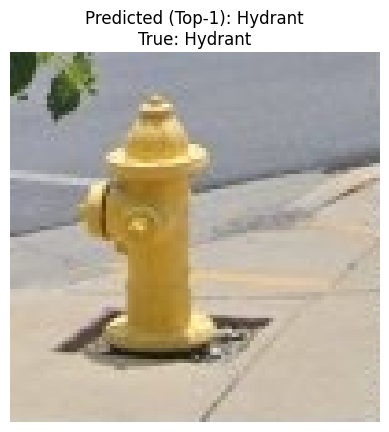

쿼리 '0a0b6944-ff0b-48d8-8d29-e00ac857ec4e.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Bicycle


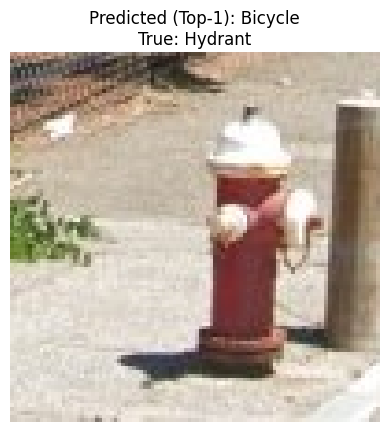

쿼리 '0a35d78b-bde9-4442-9c29-864642b5b783.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Car


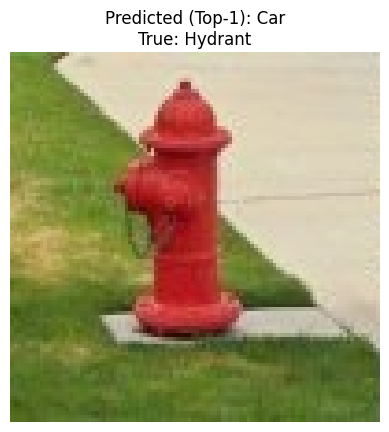

쿼리 '0a911df3-9d47-4d4a-874d-ddd08edd88f5.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Car


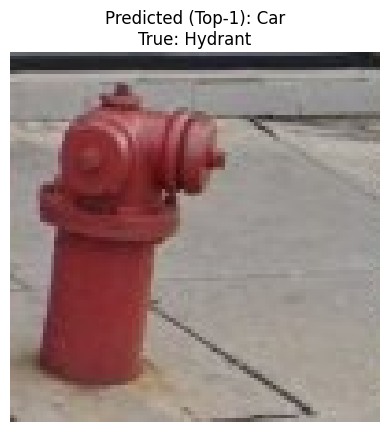

쿼리 '0accf5b0-1152-4f09-aadf-15d1c93eb5d7.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Hydrant


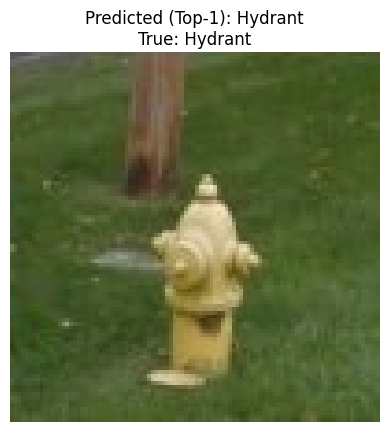

쿼리 '0c082085-e45f-4438-8a13-4ec927ac960f.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Car


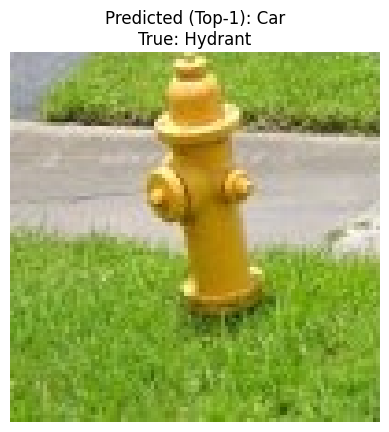

쿼리 '0c19d3b7-2bb9-4323-a574-f7594cbae46a.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Palm


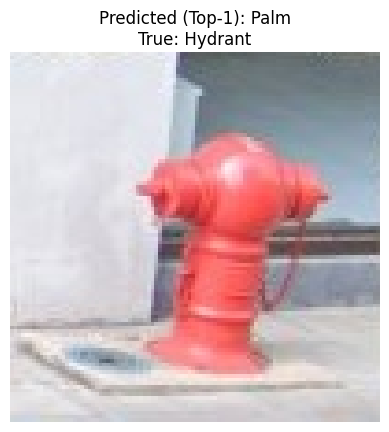

쿼리 '0d148161-167f-495c-b658-ee87f50147b9.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Bicycle


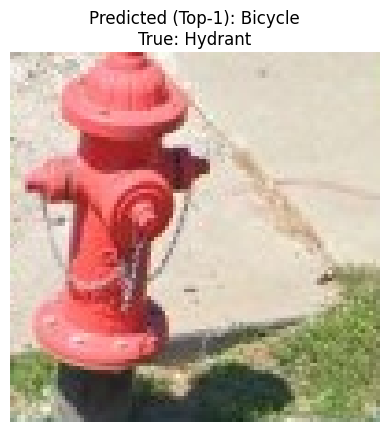

쿼리 '0df768c8-20a0-4918-9849-a9b9e1f618a6.jpg': 실제 라벨 = Hydrant, 예측 라벨 (Top-1) = Hydrant


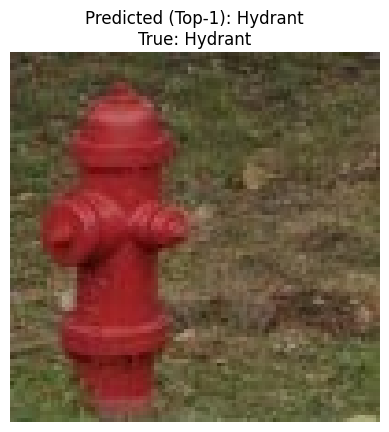

쿼리 'a0cbd7e3-42db-44c6-a813-8750756fb415.jpg': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Bicycle


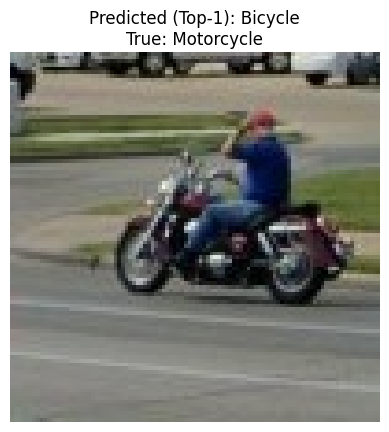

쿼리 'Motorcycle$1c99e989c20731e812ce417ac5aa3a7e.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Motorcycle


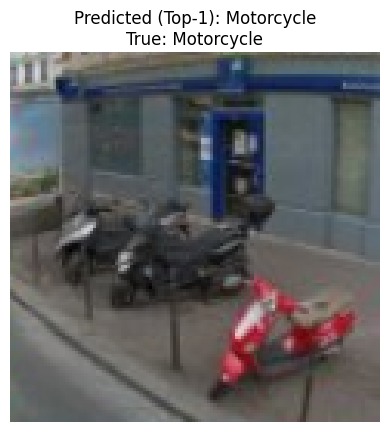

쿼리 'Motorcycle$1f2a4af456bdf0e5600a1462903353af.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Bicycle


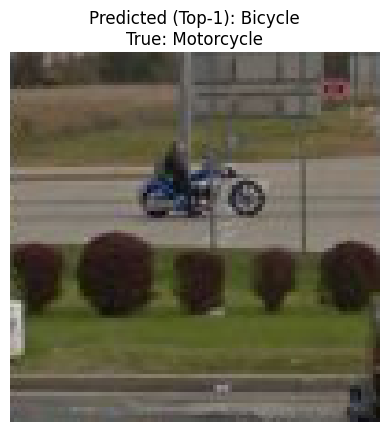

쿼리 'Motorcycle$2b9aa2e77dd1b2e202a212495235419f.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Motorcycle


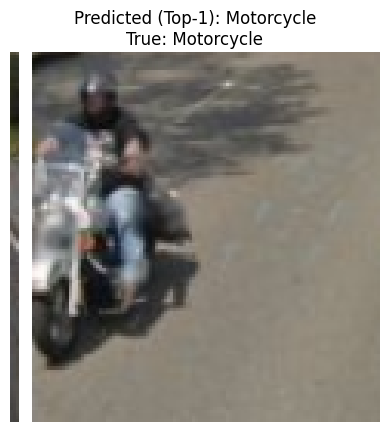

쿼리 'Motorcycle$3e1e8e5fd269c6bd3ac53040208562b5.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Motorcycle


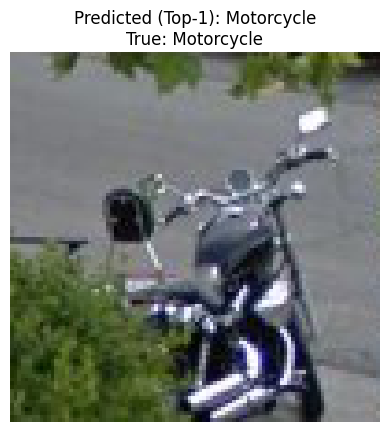

쿼리 'Motorcycle$46fe50c881e045f14f3ba7bd3c2dcc13.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Crosswalk


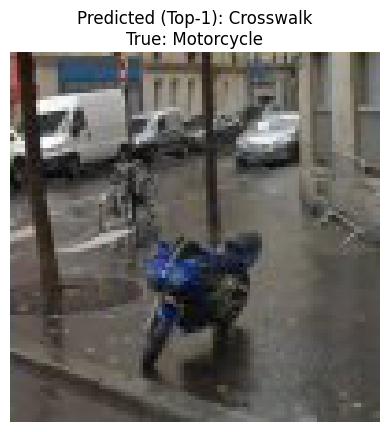

쿼리 'Motorcycle$51dd11e4290bf9403e4c4959e73604ca.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Car


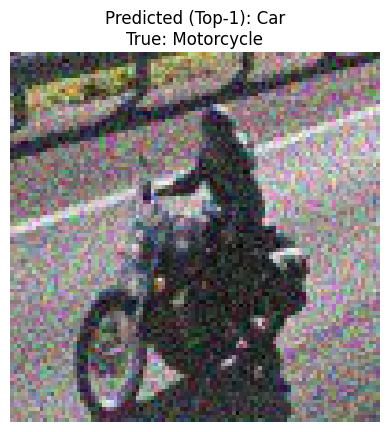

쿼리 'Motorcycle$5dfd75fa30cf6dc5f72961755f3d869c.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Motorcycle


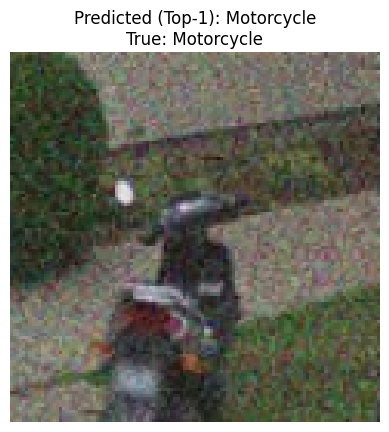

쿼리 'Motorcycle$8f84157818c382a2e7609996d6f15be4.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Motorcycle


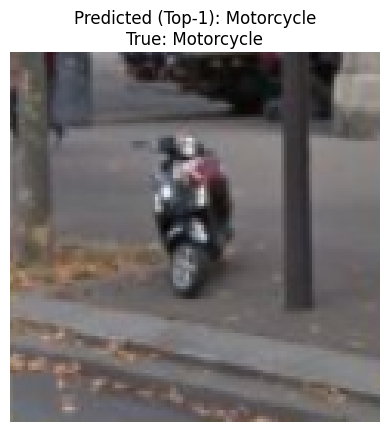

쿼리 'Motorcycle$994250ad3501b69bc32b645adb6d9233.png': 실제 라벨 = Motorcycle, 예측 라벨 (Top-1) = Crosswalk


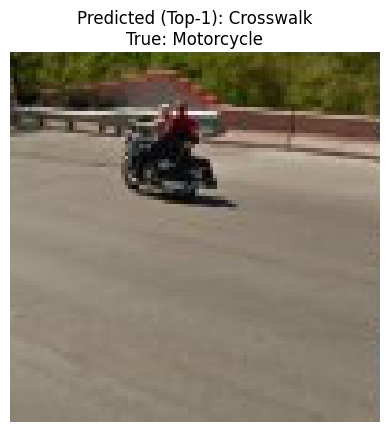

쿼리 '1a255fab-b38e-41f5-a3e9-29db14b994b3.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


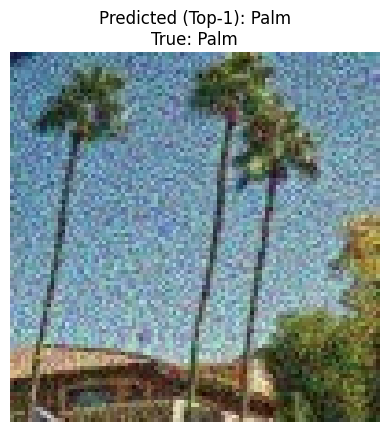

쿼리 '1cc7ea4e-3204-4374-8335-c9f9d2f22dd3.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


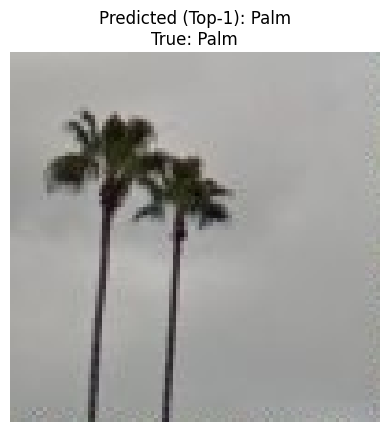

쿼리 '1e1d4213-2ff3-437a-8af5-1e1acc575402.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


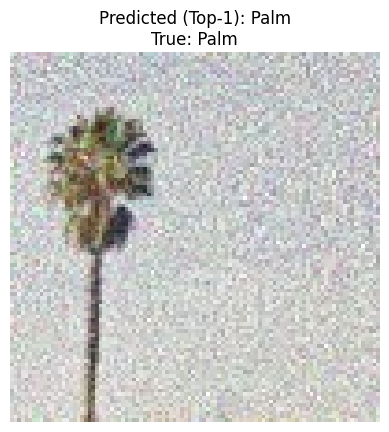

쿼리 '591d92d7-9bf2-4867-ac8b-3d6396d19a24.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Traffic Light


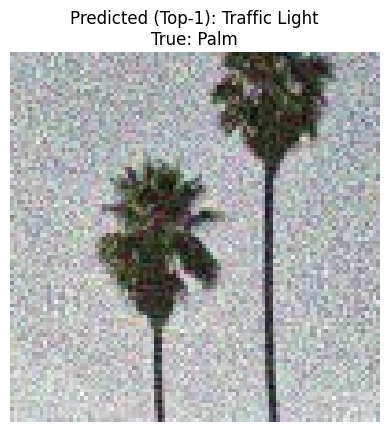

쿼리 '80ed6d99-6e66-41c1-982e-b71be019e7f8.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


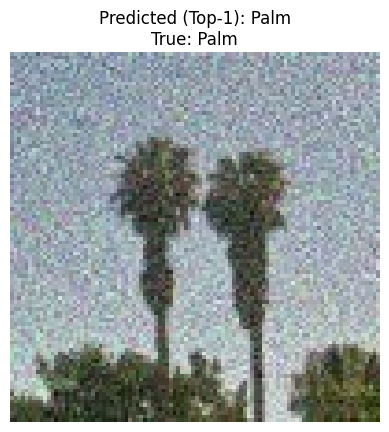

쿼리 '87acd615-c227-41dc-9d31-a033b4d305a2.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


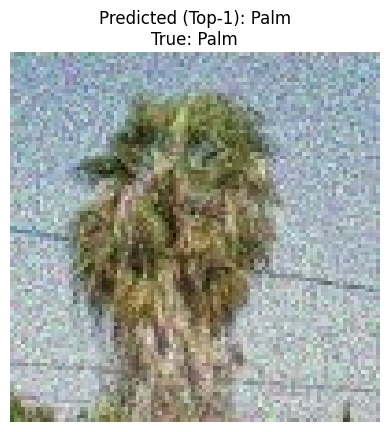

쿼리 '8a84891e-7387-4258-9605-f67fd7b35ecf.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


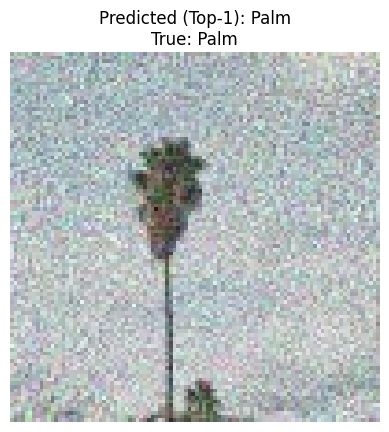

쿼리 '8caebddb-a401-466b-bdae-abebd6518404.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


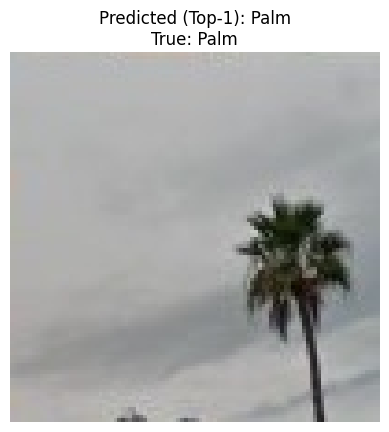

쿼리 '9d8172e7-5e9d-4d54-aedc-b75b6b73b39d.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


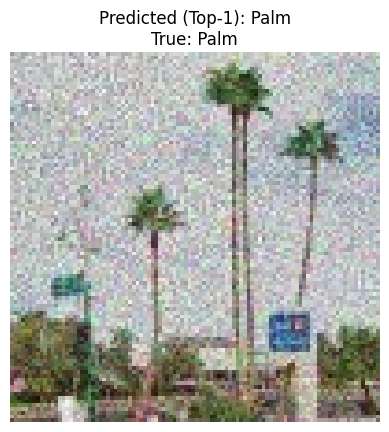

쿼리 '9e442383-5c60-4357-931a-6dae373abd48.jpg': 실제 라벨 = Palm, 예측 라벨 (Top-1) = Palm


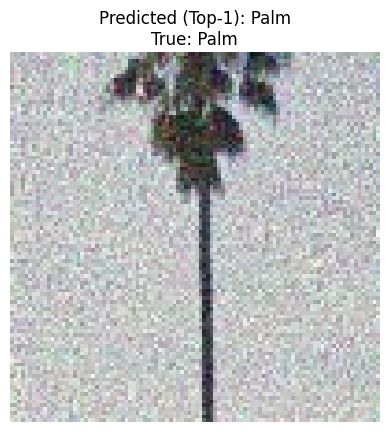

쿼리 '004c4590-81d5-49de-83dd-2abba19cb5f6.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Hydrant


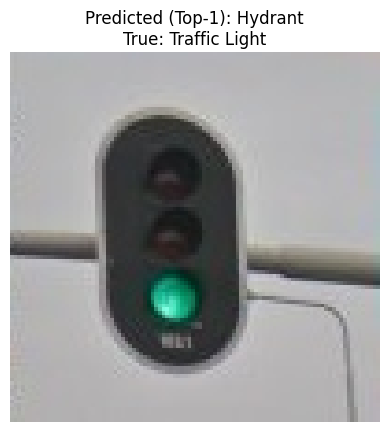

쿼리 '00ef9784-4dd4-45eb-9b94-e73cadd8e2f9.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Palm


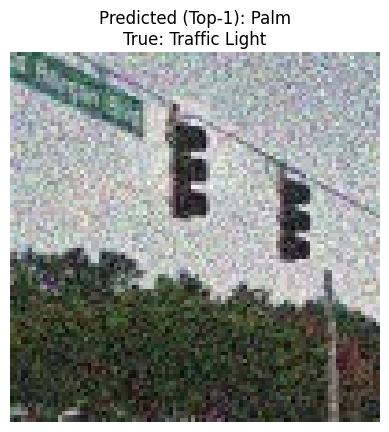

쿼리 '0add9afc-dd63-43f0-9990-418772945b7b.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Palm


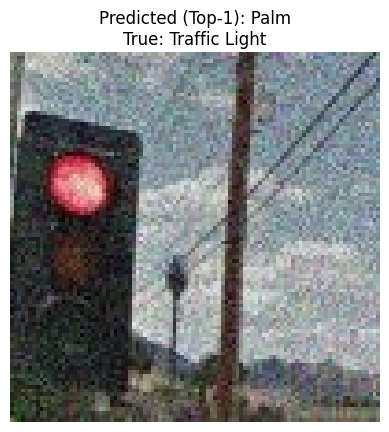

쿼리 '0b1fb39b-9dff-447c-8ed4-b59b935ab8cb.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Traffic Light


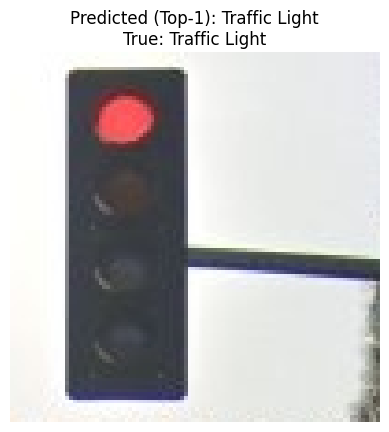

쿼리 '0bb774c7-ea1f-4da7-a169-1cc3ae9f5198.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Palm


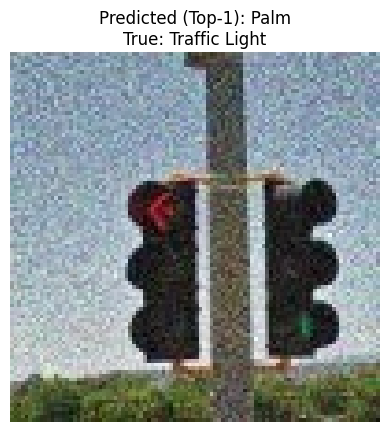

쿼리 '2b265876-47c0-4344-ae52-9a3b16ba0fbc.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Car


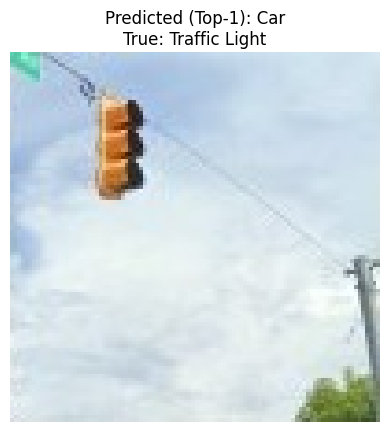

쿼리 '3a77a2a4-fac9-4288-9ac0-fd0d84eea856.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Bicycle


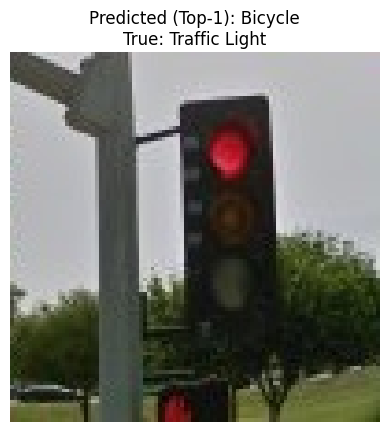

쿼리 '4afeaf0b-93e3-473d-b269-5ce4711c6cc7.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Traffic Light


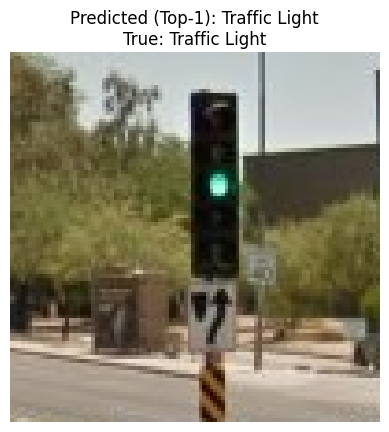

쿼리 '4bab87dc-e9c4-4b06-b02b-a946665aeb07.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Palm


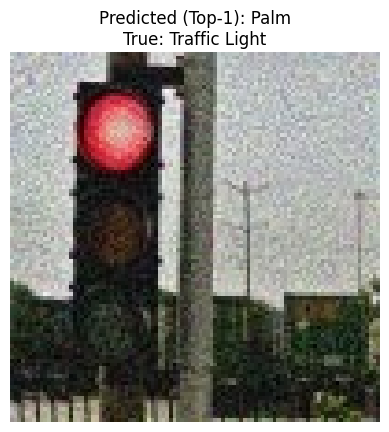

쿼리 '6e11ce6a-7a03-4984-b1db-16cd14fde21f.jpg': 실제 라벨 = Traffic Light, 예측 라벨 (Top-1) = Traffic Light


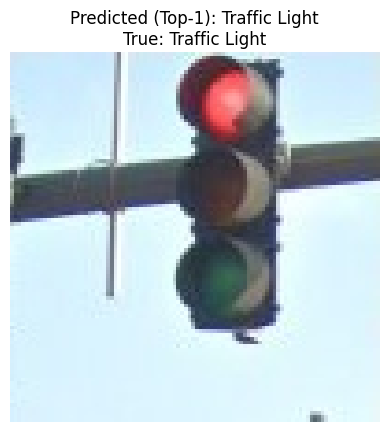

In [159]:
# ==============================================================================
#  쿼리 이미지 처리 및 예측 (수정된 코드)
# ==============================================================================

# 1. 쿼리 이미지 로드
query_df = load_images_from_folder("C:/Users/bvb09/Downloads/test/images")
print(f"✔ 총 {len(query_df)}개의 쿼리 이미지 로드 완료.")

# 2. 쿼리 이미지에 대한 특징 추출
print("⏳ 쿼리 이미지 기본 특징 추출 중 (Color, HOG, LBP, SIFT descriptors)...")

# Color Histogram 추출
query_features_color = np.array([extract_color_histogram_features(img) for img in tqdm(query_df['image_data'], desc="Query Color Histogram 추출")])
print(f"  - Color Histogram 특징 차원: {query_features_color.shape}")

# LBP 추출
query_features_lbp = np.array([extract_lbp_features_from_array(img) for img in tqdm(query_df['image_data'], desc="Query LBP 추출")])
print(f"  - LBP 특징 차원: {query_features_lbp.shape}")

# HOG 추출
query_hog_list = [
    extract_hog_features(img)
    for img in tqdm(query_df['image_data'], desc="Query HOG 추출")
]
query_features_hog = np.vstack(query_hog_list)
print(f"  - HOG 원본 특징 차원: {query_features_hog.shape}")

# HOG PCA 변환 (학습 시 사용한 pca_hog 모델을 그대로 사용)
if 'pca_hog' in locals() and pca_hog is not None:
    query_features_hog = pca_hog.transform(query_features_hog)
    print(f"  - HOG PCA 변환 완료. 변환 후 차원: {query_features_hog.shape}")
else:
    print("  ⚠️ pca_hog 모델이 정의되지 않았습니다. HOG PCA를 건너뜁니다.")

# SIFT 디스크립터 추출
query_sift_descriptors_list = [extract_sift_descriptors_from_array(img) for img in tqdm(query_df['image_data'], desc="Query SIFT Descriptors 추출")]

# SIFT 디스크립터 PCA 변환 (학습 시 사용한 pca_sift 모델을 그대로 사용)
if 'pca_sift' in locals() and pca_sift is not None:
    query_sift_descriptors_list = [
        pca_sift.transform(des) if des is not None and des.shape[1] == 128 else None
        for des in query_sift_descriptors_list
    ]
    print(f"  - SIFT 디스크립터 PCA 변환 완료.")
else:
    print("  ⚠️ pca_sift 모델이 정의되지 않았습니다. SIFT PCA를 건너뜜니다.")


# BoVW Histogram 생성 (학습 시 사용한 bovw_vocabulary를 그대로 사용)
valid_query_sift_descriptors_list = [des for des in query_sift_descriptors_list if des is not None]

if valid_query_sift_descriptors_list:
    query_bovw_hist = np.array(parallel_create_bovw_histograms(valid_query_sift_descriptors_list, bovw_vocabulary, n_jobs=-1))
    temp_bovw_hist_idx = 0
    final_query_bovw_hist = []
    for des in query_sift_descriptors_list:
        if des is not None:
            final_query_bovw_hist.append(query_bovw_hist[temp_bovw_hist_idx])
            temp_bovw_hist_idx += 1
        else:
            final_query_bovw_hist.append(np.zeros(bovw_vocabulary.shape[0]))
    query_bovw_hist = np.array(final_query_bovw_hist)
    print(f"  - BoVW Histogram 차원: {query_bovw_hist.shape}")
else:
    print("  ⚠️ 쿼리 이미지에서 SIFT 디스크립터가 없어 BoVW Histogram을 생성할 수 없습니다. 0 벡터로 채웁니다.")
    query_bovw_hist = np.zeros((len(query_df), bovw_vocabulary.shape[0]))


print("✔ 쿼리 이미지 특징 추출 완료.")

# 3. 모든 특징 결합 (학습 시와 동일한 순서와 방식으로 결합)
query_X_features_list = [
    query_features_color,
    query_features_lbp,
    query_features_hog,
    query_bovw_hist
]
X_query_combined = combine_features(*query_X_features_list).astype(np.float32)

print(f"✔ 쿼리 이미지 통합 특징 벡터 생성 완료. Shape: {X_query_combined.shape}")

# 4. 학습된 Faiss KNN 모델로 예측 수행
print("⏳ 쿼리 이미지 예측 및 Top-N Accuracy 계산 중...")

# 쿼리 이미지의 실제 라벨 추출 (load_images_from_folder에서 'image_path'를 반환하므로 가능)
# 각 이미지의 상위 폴더 이름이 라벨이라고 가정합니다.
query_true_labels = [os.path.basename(os.path.dirname(path)) for path in query_df['image_path']]
query_true_labels_encoded = le.transform(query_true_labels)


# Top-10 예측 결과 가져오기 (predict_faiss_knn_topk 함수 사용)
D, I, predicted_neighbor_labels_top10 = predict_faiss_knn_topk(
    faiss_index, train_labels_for_pred, X_query_combined, k=10
)

# Top-1 예측 라벨 (가장 가까운 이웃의 라벨)
predicted_labels_encoded_top1 = predicted_neighbor_labels_top10[:, 0]
predicted_labels_top1 = le.inverse_transform(predicted_labels_encoded_top1)

print("✔ 쿼리 이미지 예측 완료.")


# 5. Accuracy 계산
print("\n--- Accuracy 계산 ---")

# Top-1 Accuracy 계산
correct_top1 = (predicted_labels_encoded_top1 == query_true_labels_encoded).sum()
total_queries = len(query_df)
top1_accuracy = correct_top1 / total_queries

print(f"총 쿼리 이미지 개수: {total_queries}개")
print(f"Top-1 정답 개수: {correct_top1}개")
print(f"Top-1 Accuracy: {top1_accuracy:.4f}")

task2_topk_accuracy = task2_score(query_true_labels_encoded, predicted_neighbor_labels_top10, topk=10)
print(f"Task2 Accuracy (Top-10 Same-Class): {task2_topk_accuracy:.4f}")
# --------------------------------------------------


# 6. 예측 결과 개별 출력 (예시) - 여기서는 Top-1 결과만 출력합니다.
print("\n--- 쿼리 이미지 예측 결과 (Top-1) ---")
import os # os 모듈이 임포트 되어있지 않을 경우를 대비
import matplotlib.pyplot as plt # plt도 임포트되어 있는지 확인
for i, pred_label in enumerate(predicted_labels_top1):
    image_identifier = os.path.basename(query_df['image_path'].iloc[i]) # 파일 이름으로 식별
    true_label_name = le.inverse_transform([query_true_labels_encoded[i]])[0]
    print(f"쿼리 '{image_identifier}': 실제 라벨 = {true_label_name}, 예측 라벨 (Top-1) = {pred_label}")
    
    # 이미지 시각화 (선택 사항)
    plt.imshow(cv2.cvtColor(query_df['image_data'].iloc[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted (Top-1): {pred_label}\nTrue: {true_label_name}")
    plt.axis('off')
    plt.show()